任务一：
针对微博数据中的主题为“疫情”的微博，对其“热搜内容”进行分词，计算词出现的次数，将出现次数前20名的动词输出，将出现次数前20名的名词输出，并采用“词云”可视化输出（可以定义多个时间段，看舆情的变化）

In [58]:
import matplotlib.pyplot as plt
# Date: 2023.3.24
# Editor: ThreeLiu
# Course: NLP

import pandas as pd
import jieba
import wordcloud
from collections import Counter
import os

weibo_path = '微博热搜标注.xlsx'
rumor_path = 'DXYRumors.csv'
# detect_date='2020-02-21'
year = '2020'
month = '02'
date = '21'


In [59]:
weibo_data = pd.read_excel(weibo_path)
df_weibo = pd.DataFrame(weibo_data)
rumor_path = pd.read_csv(rumor_path)
df_rumor = pd.DataFrame(rumor_path)

In [60]:
# 显示所有可用时间
time = []
for i in list(df_weibo.时间.unique()):
    i = str(i)[:10]
    if len(i) == 10:
        time.append(i)
print(time)

['2020-02-21', '2020-02-20', '2020-02-19', '2020-02-18', '2020-02-17', '2020-02-16', '2020-02-15', '2020-02-14', '2020-02-13', '2020-02-12', '2020-02-11', '2020-02-10', '2020-02-09', '2020-02-08', '2020-02-07', '2020-02-06', '2020-02-05', '2020-02-04', '2020-02-03', '2020-02-02', '2020-02-01', '2020-01-31', '2020-01-30', '2020-01-29', '2020-01-28', '2020-01-27', '2020-01-26', '2020-01-25', '2020-01-24', '2020-01-23', '2020-01-22', '2020-01-21', '2020-01-20', '2020-01-19', '2020-01-18', '2020-01-16', '2020-01-15', '2020-01-14', '2020-01-11', '2020-01-09']


In [61]:
entity_list = ['新型冠状病毒/8/nz', '冠状病毒/8/nz', '疫情地图/8/nz', '武汉肺炎/8/nz', '人传人/8/n', '病毒/8/nz',
               '疫情/8/nz',
               '病例', '新冠/8/nz', 'SARS/8/nz', '隔离', '口罩', '卫健委/5/nt', '双黄连/8/nz', '埃博拉/3/nz',
               '瑞德西韦/5/nz',
               '金银潭/5/nz', '百步亭/5/nz', '火神山/5/nz', '雷神山/5/nz', '张家界/5/ns', '小汤山/5/nz',
               '威斯特丹号/5/nz', '钻石公主号/5/nz',
               '方舱医院/5/nz', '同济医院/3/nz', '协和医院/3/nz', '紫外线', '蝙蝠/3/nz', '酒精', '消毒', '确诊',
               '连闯/2/v',
               '康复/3/n', '封城/3/n', '汤圆/3/n', '武软/3/nt', '红十字会/3/nt', '马拉松/3/n', '小姐姐/3/r',
               '医护人员/5/nr', '医疗队/5/nr', '医院院长/5/nr', '张定宇/5/nr', '护士/5/nr', '医生/5/nr',
               '钟南山/5/nr', '李兰娟/5/nr', '李文亮/5/nr', '应勇/5/nr', '王贺胜/5/nr', '王忠林/5/nr']
for w in entity_list:
    #print(w)
    w_list = w.split('/')
    freq, tag = 1, None
    if len(w_list) > 1:
        # [word freq]
        freq = w_list[1]
    if len(w_list) > 2:
        # [word freq tag]
        tag = w_list[2]
    #jieba.add_word(w)
    jieba.add_word(w_list[0], freq=freq, tag=tag)


In [107]:
import paddle


def show_weibo_cloud(time, year, month, date, key_word: str):
    epidemic_dir = {}
    detect_dates = []
    detect_date = year + '-' + month + '-' + date
    if detect_date in time:
        detect_dates.append(detect_date)
    else:
        print('输入日期不在可用日期范围内')
        return None
    detect_date = year + '-' + month + '-' + str(int(date) + 1)
    if detect_date in time:
        detect_dates.append(detect_date)
    detect_date = year + '-' + month + '-' + str(int(date) - 1)
    if detect_date in time:
        detect_dates.append(detect_date)
    # 根据关键词和时间筛选数据
    for i in range(len(df_weibo)):
        if key_word in str(df_weibo.主题[i]) and any(time in str(df_weibo.时间[i]) for time in detect_dates):
            epidemic_dir[i] = df_weibo.主题[i]
    # print(epidemic_dir)
    index = list(epidemic_dir.keys())
    # print(len(index))
    words = []
    words_p=[]
    # 分词
    paddle.enable_static()
    jieba.enable_paddle()
    paddle.enable_static()
    for content in df_weibo.热搜内容[index]:
        words_p.extend(jieba.cut(content, use_paddle=True))

    for content in df_weibo.热搜内容[index]:
        words.extend(jieba.lcut(content, cut_all=True))
    # print(len(words))
    word_count = Counter(words)
    word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    # print(word_count[:20])

    word_p_count = Counter(words_p)
    word_p_count = sorted(word_p_count.items(), key=lambda x: x[1], reverse=True)
    def show_word_cloud(word_count):
        from jieba import posseg
        import matplotlib.pyplot as plt

        v = []
        n = []
        v_dict = {}
        n_dict = {}
        for word in word_count:
            if posseg.lcut(word[0])[0].flag == 'v':
                v.append(word[0])
                v_dict[word[0]] = word[1]
            elif posseg.lcut(word[0])[0].flag == 'n':
                n.append(word[0])
                n_dict[word[0]] = word[1]
            else:
                continue
            if len(v) >= 20 and len(n) >= 20:
                break

        print("排名前{}的动词为:{}".format(len(v[:20]), v[:20]))
        print("排名前{}的名词为:{}".format(len(n[:20]), n[:20]))
        # 输出词云
        v_cloud = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=1000,
                                      height=700).generate_from_frequencies(v_dict)
        n_cloud = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=1000,
                                      height=700).generate_from_frequencies(n_dict)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.title('WordCloud_v(date={})'.format(year + '-' + month + '-' + date))
        plt.imshow(v_cloud)
        plt.axis('off')
        plt.subplot(122)
        plt.title('WordCloud_n(date={})'.format(year + '-' + month + '-' + date))
        plt.imshow(n_cloud)
        plt.axis('off')
        plt.show()
    show_word_cloud(word_count)
    show_word_cloud(word_p_count)

Paddle enabled successfully......
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


排名前20的动词为:['例', '新增', '确诊', '诊病', '累计', '可', '死亡', '出现', '增至', '感', '倍增', '接触', '超', '感冒', '恢复', '成立', '救治', '可能', '聚集', '分离']
排名前20的名词为:['肺炎', '病例', '乘客', '全国', '冠状', '地图', '首例', '医院', '年龄', '年龄组', '时间', '病情', '区分', '流感', '病人', '抗病', '抗病毒', '喷剂', '医疗', '总医院']


C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.texts

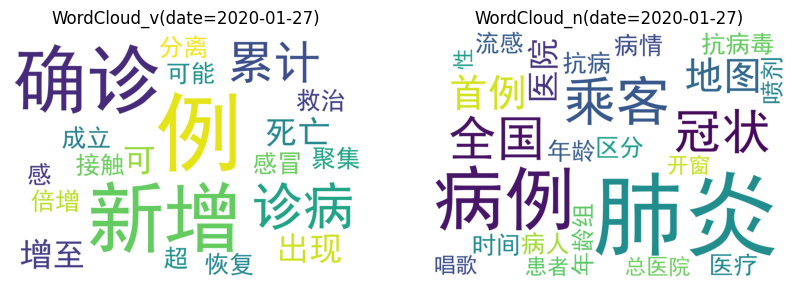

排名前20的动词为:['新增', '确诊', '累计', '可', '死亡', '出现', '增至', '倍增', '接触', '感冒', '恢复', '成立', '救治', '可能', '聚集性', '分离', '到', '乘晋', '离开', '可达']
排名前20的名词为:['肺炎', '病例', '乘客', '全国', '地图', '首例', '年龄', '时间', '病情', '区分', '流感', '轻症', '病人', '抗病毒喷剂', '医疗', '总医院', '患者', '开窗', '唱歌', '原']


C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\17248\.conda\envs\nlp\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pil

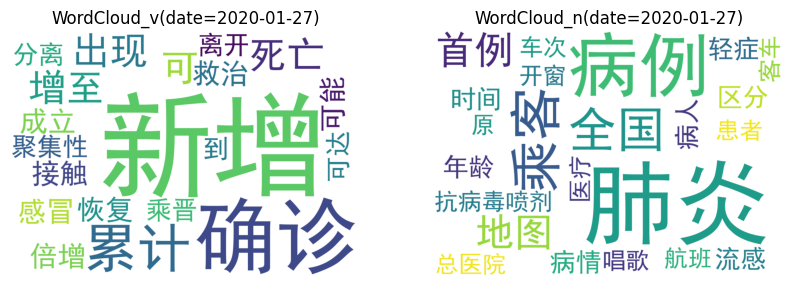

In [108]:
show_weibo_cloud(time, year='2020', month='01', date='27', key_word='疫情')

任务二：
针对微博数据中的主题为“政府”的微博，对其“热搜内容”进行分词，计算词出现的次数，将出现次数前20名的动词输出，将出现次数前20名的名词输出，并采用“词云”可视化输出。（可以定义多个时间段，看随着时间的舆情变化）

排名前9的动词为:['负担', '用财', '确诊', '疑似', '付费', '安排', '回应', '求助', '处理']
排名前13的名词为:['肺炎', '个人', '财政', '患者', '费用', '资金', '副省长', '省长', '市民', '网络', '公职', '公职人员', '人员']


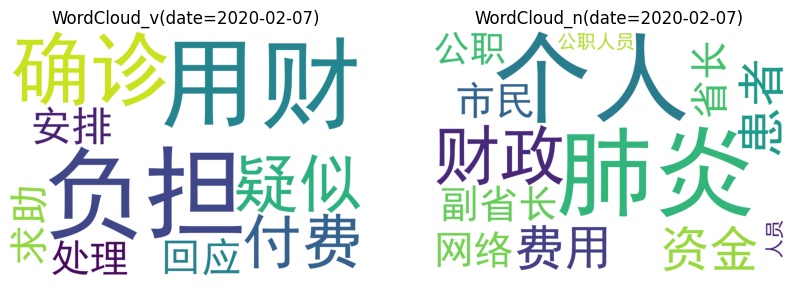

In [64]:
show_weibo_cloud(time, year='2020', month='02', date='07', key_word='政府')

任务三：
针对谣言数据，对“title”内容进行分词，计算词出现的次数，将出现次数前10名的为动词输出，将出现次数前10名的名词输出，出现次数前10的词（不考虑词性）输出，并采用“词云”可视化输出.（不定义时间段）

In [66]:
import re
import jieba.posseg as posseg
from collections import Counter
import wordcloud
import matplotlib.pyplot as plt


def show_rumor_cloud(key_word='title'):
    rumors = []
    for i in range(len(df_rumor[key_word].to_list())):
        rumors.append((i + 1, df_rumor[key_word].to_list()[i]))
    words = []
    for rumor in rumors:
        words.extend(jieba.lcut(re.sub(r'[^\w\s]', '', rumor[1])))
    word_count = Counter(words)
    word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    v = {}
    n = {}
    w = {}
    for word in word_count:
        if posseg.lcut(word[0])[0].flag == 'v':
            v[word[0]] = word[1]
            w[word[0]] = word[1]
        elif posseg.lcut(word[0])[0].flag == 'n':
            n[word[0]] = word[1]
            w[word[0]] = word[1]
        else:
            if word[0] != " ":
                w[word[0]] = word[1]
            continue
        if len(v) >= 10 and len(n) >= 10:
            break
    v_dict = v.copy()
    n_dict = n.copy()
    w_dict = dict(sorted(w.items(), key=lambda x: x[1], reverse=True)[:10])
    v = sorted(v.items(), key=lambda x: x[1], reverse=True)
    n = sorted(n.items(), key=lambda x: x[1], reverse=True)
    w = sorted(w.items(), key=lambda x: x[1], reverse=True)
    print("排名前{}的动词为:{}".format(len(v[:10]), [x[0] for x in v[:10]]))
    print("排名前{}的名词为:{}".format(len(n[:10]), [x[0] for x in n[:10]]))
    print("排名前{}的词为:{}".format(len(w[:10]), [x[0] for x in w[:10]]))
    # print(type(n))
    # 输出词云
    v_cloud = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=1000,
                                  height=700).generate_from_frequencies(v_dict)
    n_cloud = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=1000,
                                  height=700).generate_from_frequencies(n_dict)
    w_cloud = wordcloud.WordCloud(font_path='C:/Windows/Fonts/simhei.ttf', background_color='white', width=1000,
                                  height=700).generate_from_frequencies(w_dict)
    plt.Figure(figsize=(10, 5))
    plt.subplot(131)
    plt.title('WordCloud_v')
    plt.imshow(v_cloud)
    plt.axis('off')
    plt.subplot(132)
    plt.title('WordCloud_n')
    plt.imshow(n_cloud)
    plt.axis('off')
    plt.subplot(133)
    plt.title('WordCloud_w')
    plt.imshow(w_cloud)
    plt.axis('off')
    plt.show()

排名前10的动词为:['预防', '感染', '会', '吃', '可', '能', '有', '是', '杀灭', '要']
排名前10的名词为:['口罩', '肺炎', '宠物', '人', '酒精', '效果', '人会', '染病', '电吹风', '绒线']
排名前10的词为:['新冠', '病毒', '可以', '的', '预防', '感染', '会', '吃', '消毒', '可']


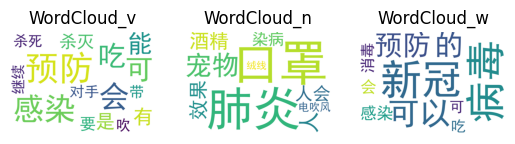

In [67]:
show_rumor_cloud()

任务四：
统计同一日期下的“疫情”相关微博数量和谣言数量，并绘制曲线图，观察随着时间的变化，舆情的变化。

In [81]:
times = {}
for i in df_rumor.crawlTime.to_list():
    times[i[:10]] = times.get(i[:10], 0) + 1
# print(df_rumor.crawlTime.to_list())
print(times)

{'2020-03-06': 2, '2020-03-03': 1, '2020-03-02': 6, '2020-02-28': 3, '2020-02-25': 2, '2020-02-24': 4, '2020-02-23': 2, '2020-02-22': 3, '2020-02-21': 3, '2020-02-20': 3, '2020-02-19': 81, '2020-01-31': 39, '2020-01-30': 30, '2020-01-29': 105}


{'2020-02-21': 16, '2020-02-20': 7, '2020-02-19': 8, '2020-02-18': 6, '2020-02-17': 8, '2020-02-16': 11, '2020-02-15': 7, '2020-02-14': 7, '2020-02-13': 5, '2020-02-12': 8, '2020-02-11': 6, '2020-02-10': 7, '2020-02-09': 10, '2020-02-08': 9, '2020-02-07': 14, '2020-02-06': 15, '2020-02-05': 18, '2020-02-04': 18, '2020-02-03': 10, '2020-02-02': 13, '2020-02-01': 12, '2020-01-31': 13, '2020-01-30': 14, '2020-01-29': 24, '2020-01-28': 26, '2020-01-27': 13, '2020-01-26': 21, '2020-01-25': 17, '2020-01-24': 20, '2020-01-23': 15, '2020-01-22': 7, '2020-01-21': 6, '2020-01-20': 7, '2020-01-19': 2, '2020-01-18': 1, '2020-01-16': 1, '2020-01-15': 2, '2020-01-14': 1, '2020-01-11': 1, '2020-01-09': 1}


C:\Users\17248\AppData\Local\Temp\ipykernel_30664\3463601565.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=epidemic_dates,rotation=45)


<Figure size 640x480 with 0 Axes>

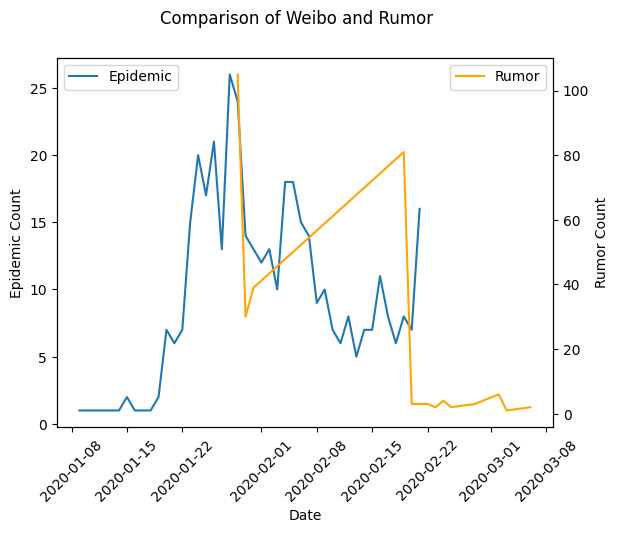

In [100]:
import datetime
import matplotlib.dates as mdates

def compare_weibo_and_rumor():
    epidemic_dir = {}
    for i in range(len(df_weibo)):
        if "疫情" in str(df_weibo.主题[i]):
            epidemic_dir[str(df_weibo.时间[i])[:10]] = epidemic_dir.get(str(df_weibo.时间[i])[:10], 0) + 1
        else:
            continue
    print(epidemic_dir)

    rumor_dir = {}
    for i in df_rumor.crawlTime.to_list():
        rumor_dir[i[:10]] = rumor_dir.get(i[:10], 0) + 1
    # 得到两个字典，开始使用plt绘图
    plt.figure()

    # 提取字典中信息放入列表
    epidemic_dates = list(epidemic_dir.keys())
    rumor_dates = list(rumor_dir.keys())

    # 将时间格式化方便排序
    epidemic_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in epidemic_dates]
    rumor_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in rumor_dates]
    epidemic_dates.sort()
    rumor_dates.sort()

    epidemic_counts_sorted = [epidemic_dir[date.strftime('%Y-%m-%d')] for date in epidemic_dates]
    rumor_counts_sorted = [rumor_dir[date.strftime('%Y-%m-%d')] for date in rumor_dates]

    fig, ax1 = plt.subplots()

    ax1.plot(epidemic_dates, epidemic_counts_sorted, label='Epidemic')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Epidemic Count')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()

    ax2.plot(rumor_dates, rumor_counts_sorted, color='orange', label='Rumor')
    ax2.set_ylabel('Rumor Count')
    ax2.tick_params(axis='y')
    ax1.set_xticklabels(labels=epidemic_dates,rotation=45)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.suptitle('Comparison of Weibo and Rumor')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()



compare_weibo_and_rumor()